# OBJECTIF ET CONTEXTE #

L’INSEE publie chaque année un taux de pauvreté associé à des zones géographiques.
Dans notre dataset, et alors que cette donnée est un indicateur principal pour l’étude des inégalités, 87,6% des taux sont manquants. Cependant, les 12,4% de données disponibles représentent tout de même 4.325 zones géographiques et donc un potentiel suffisant pour  appliquer des techniques de Machine Learning, l’objectif étant de prédire les données manquantes à partir de variables pertinentes pour un président d’agglomération cherchant à lutter contre les inégalités.

La modélisation donnera lieu, dans un second temps, à la création d’un outil Streamlit à partir duquel la variation de variables explicatives fera fluctuer l’indicateur de pauvreté, notre variable cible nommée TP6020.

La variable TP6020 est une variable publiée par l’INSEE correspondant au taux de pauvreté en 2020. Ce taux est calculé pour les personnes logées de manière ordinaire en France métropolitaine. Il exclut donc les sans-abris et les populations occupant des habitations mobiles. Les ménages dont la personne de référence est étudiante sont aussi exclus de l’analyse. Ce taux est calculé par l’INSEE à partir de l’enquête Revenus fiscaux et sociaux (ERFS), réalisée annuellement.
Détermination des variables explicatives
Contexte

Notre jeu de données initial contient 738 variables de l’INSEE et 34.955 lignes (communes).

Les dénominations, descriptions, thématiques et le nombre de données manquantes par variable peuvent être consultées [ici](https://docs.google.com/spreadsheets/d/1DtyFTiprlnxWawDKxqjiR8y03np2ra3L6a9YIVuVnPQ/edit#gid=1496962940).

Afin de prédire notre variable cible, nous nous sommes fixées plusieurs règles pour déterminer nos variables explicatives : 

- Trouver 3 à 5 variables présentant une corrélation avec notre variable cible
- Que les variables sélectionnées soient pertinentes pour un président d’agglomération
- Que les variables sélectionnées soient relativement décorellées entre elles (agir sur l’une de ces variables ne doit pas impacter les autres)

Le jeu de données initial contenant parfois beaucoup de données manquantes que nous pouvions difficilement remplacer par des valeurs moyennes ou médianes sans biaiser notre étude, nous l’avons réduit de manière à ne garder que les communes pour lesquelles nous avions l’ensemble des données. Cela impliquait également la suppression d’un nombre marginal de variables. Après cette transformation, le jeu de données contenait 719 variables pour 4.249 lignes (communes). 

Malgré la réduction importante du nombre de communes, le jeu de données représentait cependant une population de 48,2 M d’habitants, soit un peu plus de 71% de la population française.


## IMPORT DES LIBRAIRIES ##

In [1]:
import pandas as pd
import numpy as np

#élargissement de la visualisation des tableaux pandas
pd.set_option('display.max_columns', None)

#suppression des warnings
import warnings
warnings.filterwarnings('ignore')

#visualisations
import seaborn as sns
import matplotlib.pyplot as plt

#stats
from scipy.stats import pearsonr

#modélisation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.pipeline import Pipeline


## IMPORT DU DATASET ##

In [2]:
df = pd.read_csv('../files/dataframe_complet.csv', dtype={'CODGEO': 'string', 'num_dep': 'string'})

In [3]:
#Suppréssion de variables trop incomplètes ou directement liées à notre variable cible (TP6020)
df = df.drop(['Unnamed: 0', 
             'P19_RP_MIDUR', 
             'P19_RP_MIBOIS', 
             'P19_RP_CASE', 
             'P19_RP_HABFOR', 
             'P19_RP_TTEGOU', 
             'P19_RP_CLIM',
             'P19_RP_ELEC',
             'P19_RP_EAUCH',
             'P19_RP_BDWC',
              'P19_RP_CHOS',
              'TP60AGE620',
              'TP60AGE120',
              'TP60AGE520',
              'TP60AGE420',
              'TP60AGE220',
              'TP60AGE320',
              'TP60TOL120',
              'TP60TOL220'],axis=1)

In [4]:
df = df[df['TP6020'].isna() == False].reset_index(drop=True)
df = df.dropna().reset_index(drop=True)

In [5]:
df.head(3)

,CODGEO,EU_circo,num_region,num_dep,nom_commune,nom_dep,nom_region,num_chef_lieu,nom_chef_lieu,code_postal,latitude,longitude,pop_tot,SUPERF,P19_POP,P19_POP1529,P19_POP3044,P19_POP4559,P19_POP6074,P19_POP7589,P19_POP90P,P19_POPH,P19_H1529,P19_H3044,P19_H4559,P19_H6074,P19_H7589,P19_H90P,P19_H0019,P19_H2064,P19_H65P,P19_POPF,P19_F1529,P19_F3044,P19_F4559,P19_F6074,P19_F7589,P19_F90P,P19_F0019,P19_F2064,P19_F65P,P19_POP01P,P19_POP01P_IRAN1,P19_POP01P_IRAN2,P19_POP01P_IRAN3,P19_POP01P_IRAN4,P19_POP01P_IRAN5,P19_POP01P_IRAN6,P19_POP01P_IRAN7,P19_POP0114_IRAN2P,P19_POP0114_IRAN2,P19_POP0114_IRAN3P,P19_POP1524_IRAN2P,P19_POP1524_IRAN2,P19_POP1524_IRAN3P,P19_POP2554_IRAN2P,P19_POP2554_IRAN2,P19_POP2554_IRAN3P,P19_POP55P_IRAN2P,P19_POP55P_IRAN2,P19_POP55P_IRAN3P,C19_POP15P,C19_POP15P_CS1,C19_POP15P_CS2,C19_POP15P_CS3,C19_POP15P_CS4,C19_POP15P_CS5,C19_POP15P_CS6,C19_POP15P_CS7,C19_POP15P_CS8,C19_H15P,C19_H15P_CS1,C19_H15P_CS2,C19_H15P_CS3,C19_H15P_CS4,C19_H15P_CS5,C19_H15P_CS6,C19_H15P_CS7,C19_H15P_CS8,C19_F15P,C19_F15P_CS1,C19_F15P_CS2,C19_F15P_CS3,C19_F15P_CS4,C19_F15P_CS5,C19_F15P_CS6,C19_F15P_CS7,C19_F15P_CS8,C19_POP1524,C19_POP1524_CS1,C19_POP1524_CS2,C19_POP1524_CS3,C19_POP1524_CS4,C19_POP1524_CS5,C19_POP1524_CS6,C19_POP1524_CS7,C19_POP1524_CS8,C19_POP2554,C19_POP2554_CS1,C19_POP2554_CS2,C19_POP2554_CS3,C19_POP2554_CS4,C19_POP2554_CS5,C19_POP2554_CS6,C19_POP2554_CS7,C19_POP2554_CS8,C19_POP55P,C19_POP55P_CS1,C19_POP55P_CS2,C19_POP55P_CS3,C19_POP55P_CS4,C19_POP55P_CS5,C19_POP55P_CS6,C19_POP55P_CS7,C19_POP55P_CS8,C19_MEN,C19_MENPSEUL,C19_MENHSEUL,C19_MENFSEUL,C19_MENSFAM,C19_MENFAM,C19_MENCOUPSENF,C19_MENCOUPAENF,C19_MENFAMMONO,C19_PMEN,C19_PMEN_MENPSEUL,C19_PMEN_MENHSEUL,C19_PMEN_MENFSEUL,C19_PMEN_MENSFAM,C19_PMEN_MENFAM,C19_PMEN_MENCOUPSENF,C19_PMEN_MENCOUPAENF,C19_PMEN_MENFAMMONO,P19_POP15P,P19_POP1519,P19_POP2024,P19_POP2539,P19_POP4054,P19_POP5564,P19_POP6579,P19_POP80P,P19_POPMEN1519,P19_POPMEN2024,P19_POPMEN2539,P19_POPMEN4054,P19_POPMEN5564,P19_POPMEN6579,P19_POPMEN80P,P19_POP1519_PSEUL,P19_POP2024_PSEUL,P19_POP2539_PSEUL,P19_POP4054_PSEUL,P19_POP5564_PSEUL,P19_POP6579_PSEUL,P19_POP80P_PSEUL,P19_POP1519_COUPLE,P19_POP2024_COUPLE,P19_POP2539_COUPLE,P19_POP4054_COUPLE,P19_POP5564_COUPLE,P19_POP6579_COUPLE,P19_POP80P_COUPLE,P19_POP15P_MARIEE,P19_POP15P_PACSEE,P19_POP15P_CONCUB_UNION_LIBRE,P19_POP15P_VEUFS,P19_POP15P_DIVORCEE,P19_POP15P_CELIBATAIRE,C19_MEN_CS1,C19_MEN_CS2,C19_MEN_CS3,C19_MEN_CS4,C19_MEN_CS5,C19_MEN_CS6,C19_MEN_CS7,C19_MEN_CS8,C19_PMEN_CS1,C19_PMEN_CS2,C19_PMEN_CS3,C19_PMEN_CS4,C19_PMEN_CS5,C19_PMEN_CS6,C19_PMEN_CS7,C19_PMEN_CS8,C19_FAM,C19_COUPAENF,C19_FAMMONO,C19_HMONO,C19_FMONO,C19_COUPSENF,C19_NE24F0,C19_NE24F1,C19_NE24F2,C19_NE24F3,C19_NE24F4P,P19_LOG,P19_RP,P19_RSECOCC,P19_LOGVAC,P19_MAISON,P19_APPART,P19_RP_1P,P19_RP_2P,P19_RP_3P,P19_RP_4P,P19_RP_5PP,P19_NBPI_RP,P19_RPMAISON,P19_NBPI_RPMAISON,P19_RPAPPART,P19_NBPI_RPAPPART,C19_RP_HSTU1P,C19_RP_HSTU1P_SUROCC,P19_RP_ACHTOT,P19_RP_ACH19,P19_RP_ACH45,P19_RP_ACH70,P19_RP_ACH90,P19_RP_ACH05,P19_RPMAISON_ACH19,P19_RPMAISON_ACH45,P19_RPMAISON_ACH70,P19_RPMAISON_ACH90,P19_RPMAISON_ACH05,P19_RPAPPART_ACH19,P19_RPAPPART_ACH45,P19_RPAPPART_ACH70,P19_RPAPPART_ACH90,P19_RPAPPART_ACH05,P19_MEN,P19_MEN_ANEM0002,P19_MEN_ANEM0204,P19_MEN_ANEM0509,P19_MEN_ANEM10P,P19_MEN_ANEM1019,P19_MEN_ANEM2029,P19_MEN_ANEM30P,P19_PMEN,P19_PMEN_ANEM0002,P19_PMEN_ANEM0204,P19_PMEN_ANEM0509,P19_PMEN_ANEM10P,P19_NBPI_RP_ANEM0002,P19_NBPI_RP_ANEM0204,P19_NBPI_RP_ANEM0509,P19_NBPI_RP_ANEM10P,P19_RP_PROP,P19_RP_LOC,P19_RP_LOCHLMV,P19_RP_GRAT,P19_NPER_RP,P19_NPER_RP_PROP,P19_NPER_RP_LOC,P19_NPER_RP_LOCHLMV,P19_NPER_RP_GRAT,P19_ANEM_RP,P19_ANEM_RP_PROP,P19_ANEM_RP_LOC,P19_ANEM_RP_LOCHLMV,P19_ANEM_RP_GRAT,P19_RP_SDB,P19_RP_CCCOLL,P19_RP_CCIND,P19_RP_CINDELEC,P19_RP_GARL,P19_RP_VOIT1P,P19_RP_VOIT1,P19_RP_VOIT2P,P19_POP0205,P19_POP0610,P19_POP1824,P19_POP2529,P19_POP30P,P19_SCOL0205,P19_SCOL0610,P19_SCOL1824,P19_SCOL2529,P19_SCOL30P,P19_H0205,P19_H0610,P19_H1824,P19_H2529,P19_H30P,P19_HSCOL0205,P19_H

In [6]:
df.shape

(4249, 719)

In [7]:
#Quelle est la population représentée après la réduction ?
df.pop_tot.sum()

48239700

## Etude des corrélations des variables brutes vs la variables cibles TP6020 ##

Notre jeu de données, mis à part certaines données géographiques telles que les noms de communes ou régions, est exclusivement constitué de variables numériques.

Afin de déterminer les corrélations entre ces variables et notre variable cible, nous avons calculé le coefficient de Pearson de chaque variable .Après n’avoir conservé que les résultats présentant une p-value inférieure à 5, nous avons pu déterminer que la très grande majorité de nos variables ne sont à priori pas liées à notre variable cible : 

In [8]:
#ouverture du déscriptif des variables et création d'un dictionnaire pour utilisation ultérieure
desc_var = pd.read_csv('../files/description_variables.csv', sep=';')
desc_var_dic = dict(list(zip(desc_var['CODVAR'], desc_var['Description'])))
theme_var_dic = dict(list(zip(desc_var['CODVAR'], desc_var['thème'])))

In [9]:
#création d'un dataframe avec le coefficient de pearson et la p-value < 5 pour l'ensemble des variables numériques disponibles.

#récupération des test de pearson dans des dictionnaires à partir d'une boucle
results_dict = {}
pvalue_dict = {}
for i in df.select_dtypes('number').columns:
    test = pearsonr(df.TP6020, df[i])
    results_dict[i] = test[0]
    pvalue_dict[i] = test[1]

#Création du dataframe    
df_results = pd.DataFrame(results_dict.items())
df_results['p_value'] = df_results[0].map(pvalue_dict)

#Renomme les colonnes
df_results.columns = ['col','score_test', 'pvalue']

#Suppression de la TP6020
df_results = df_results[df_results.col != 'TP6020']

#Ajout des descriptions et thématiques des variables
df_results['desc'] = df_results.col.map(desc_var_dic)
df_results['theme'] = df_results.col.map(theme_var_dic)

#Suppréssion des variables ayant une p-value > 5
df_results = df_results[df_results.pvalue < 5].reset_index(drop=True)

#apperçu
df_results.tail()

,col,score_test,pvalue,desc,theme
705,ETCKZ19,0.025880,9.165115e-02,Créations d'ets d’activités financières et d'a...,Démographie des entreprises
706,ETCLZ19,0.041552,6.749764e-03,Créations d'ets d’activités immobilières en 2019,Démographie des entreprises
707,ETCMN19,0.036902,1.614855e-02,"Créations d'ets d’activités spécialisées, scie...",Démographie des entreprises
708,ETCOQ19,0.062366,4.740794e-05,"Créations d'ets du secteur adm publ, enseign, ...",Démographie des entreprises
709,ETCRU19,0.077575,4.131575e-07,Créations d'ets des autres activités de servic...,Démographie des entreprises


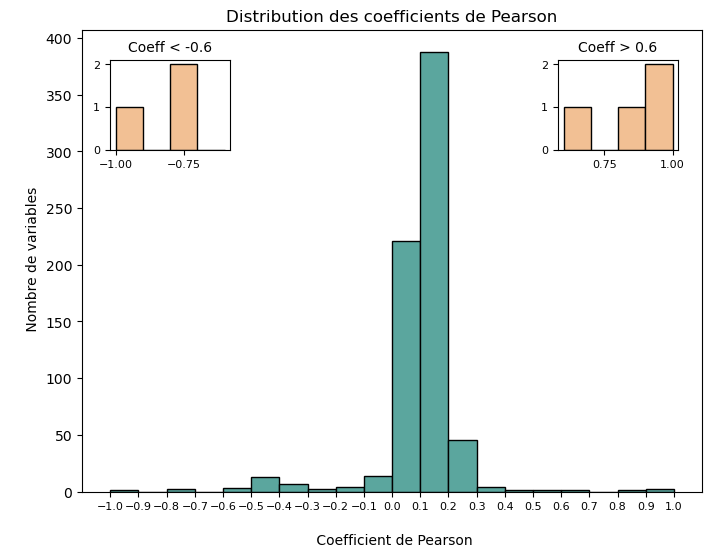

In [10]:
plt.figure(figsize=(8,6))
plt.hist(df_results.score_test, 
         bins=20,
         range = (-1,1),
         edgecolor ='black',
         color = '#5BA69E')
plt.xticks(np.arange(-1,1.1, 0.1), fontsize=8)
plt.xlabel('\n Coefficient de Pearson')
plt.ylabel('\n Nombre de variables')
plt.title('Distribution des coefficients de Pearson')

plt.axes([0.72,0.68,0.15,0.15])
plt.hist(df_results.score_test, 
         bins=4,
         range = (0.6,1),
         edgecolor ='black',
         color = '#F2C094')
plt.title('Coeff > 0.6', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.axes([0.16,0.68,0.15,0.15])
plt.hist(df_results.score_test, 
         bins=4,
         range = (-1,-0.6),
         edgecolor ='black',
         color = '#F2C094')
plt.title('Coeff < -0.6', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

Même si quelques variables semblent relativement corrélées avec notre variable cible, comme le démontre la visualisation précédente, ces variables étaient en réalité difficilement exploitables pour notre projet.

En effet, le top 4 des variables les plus corrélées positivement rassemblait des taux de prestations sociales.


In [11]:
#Top des variables les plus corrélées positivement
display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).head(4))

,col,score_test,pvalue,desc,theme
0,PPLOGT20,0.916783,0.0,dont part des prestations logement (%),Revenus et pauvreté des ménages
1,PPMINI20,0.904245,0.0,dont part des minima sociaux (%),Revenus et pauvreté des ménages
2,PPSOC20,0.891792,0.0,Part de l'ensemble des prestations sociales (%),Revenus et pauvreté des ménages
3,PPFAM20,0.617984,0.0,dont part des prestations familiales (%),Revenus et pauvreté des ménages


Si cela paraît satisfaisant de premier abord, on devine que notre modèle interprétera toute baisse de prestations sociales comme ayant un impact positif sur le taux de pauvreté, le ramenant ainsi à la baisse. Or, notre but étant qu’un président d’agglomération puisse trouver des leviers pour lutter contre les inégalités, baisser les prestations sociales pour lutter contre les inégalités semble inévitablement comme une mauvaise idée. Nous avons donc dû écarter ces variables.

Pour les variables les plus corrélées négativement, nous retrouvons une problématique similaire mais inversée avec la part des ménages fiscaux imposés. 

Le 1er décile du niveau de vie et la médiane du niveau de vie sont quant à elles des variables qui n’auraient pas suffisamment de sens pour notre outil Streamlit, la première étant un indicateur de la deuxième, et les deux étant des valeurs continues pouvant également représenter des indicateurs de pauvreté. Elles faisaient donc doublon avec notre variable cible.


In [12]:
#Top des variables les plus corrélées négativement
display(df_results.sort_values(by='score_test', ascending=True).reset_index(drop=True).head(3))

,col,score_test,pvalue,desc,theme
0,D120,-0.932794,0.0,1er décile du niveau de vie (€),Revenus et pauvreté des ménages
1,MED20,-0.731762,0.0,Médiane du niveau vie (€),Revenus et pauvreté des ménages
2,PIMP20,-0.710441,0.0,Part des ménages fiscaux imposés (%),Revenus et pauvreté des ménages


Suite à cette étude des corrélations, nous en venons à la conclusion que les données brutes intéressantes pour notre projet ne sont pas suffisamment corrélées avec la variable cible pour pouvoir réaliser une modélisation satisfaisante. Nous décidons alors de créer de nouvelles variables à partir de ces données brutes afin de réaliser une nouvelle étude de corrélations.

## Etude des corrélations des variables transformées vs la variables cibles TP6020 ##

A ce stade, nous devons changer notre approche et nous devons avant tout nous poser les bonnes questions. En regardant l’ensemble des descriptions et thématiques des variables, quels sont les indicateurs que nous pouvons créer pour servir de variable explicative pertinente à un président d’agglomération ? 

Plusieurs thématiques nous semblent primordiales : 

- chômage
- logement
- formation


### Chomage / inactivité ###

Calcul du taux de chômage 2019 des 15 à 64 ans

In [13]:
P19_ACT1564 = np.array(df.P19_ACT1564) #Population active de 15 à 64 ans
P19_CHOMEUR1564 = np.array(df.P19_CHOMEUR1564) #Population de chômeurs de 15 à 64 ans
Taux_chomage = np.array(np.round(P19_CHOMEUR1564 / P19_ACT1564 * 100,2)) #Taux de chômage en 2019

P19_POP = np.array(df.P19_POP)
P19_INACT1564 = np.array(df.P19_INACT1564)
taux_inactifs = np.array(np.round(P19_INACT1564 / P19_POP * 100,2))

### Logement ###

Calcul du taux de résidences principales de type maison en 2019

In [14]:
P19_RP = np.array(df.P19_RP) #Résidences principales en 2019 (princ)
P19_RPMAISON = np.array(df.P19_RPMAISON) #Rés princ type maison en 2019 (princ)
taux_maison_princ = np.array(np.round(P19_RPMAISON / P19_RP * 100,2)) #Taux de résidences principales de type maison en 2019

P19_POP = np.array(df.P19_POP) #Population en 2019 (princ)
P19_NPER_RP_LOC = np.array(df.P19_NPER_RP_LOC) #Pers Rés princ occupées Locataires en 2019 (princ)
taux_loc_princ = np.array(np.round(P19_NPER_RP_LOC / P19_POP * 100,2)) #Taux de personnes occupant leur résidence principale en tant que locataire en 2019


### Formation ###

Calcul du taux de non diplômés (15 ans ou plus) en 2019

In [15]:
P19_POP15P = np.array(df.P19_POP15P)#Pop 15 ans ou plus en 2019 (princ)
P19_NSCOL15P_DIPLMIN = np.array(df.P19_NSCOL15P_DIPLMIN) #Pop 15 ans ou plus non scol. Sans diplôme ou CEP en 2019 (princ)
taux_sans_diplome = np.array(np.round(P19_NSCOL15P_DIPLMIN / P19_POP15P * 100,2)) #Taux de non diplômés (15 ans ou plus) en 2019

# DATASET POUR ML #

Création d'un dataset rassemblant les nouvelles variables que nous venons de créér et la variable cible.

In [16]:
data = pd.DataFrame({'CODGEO': df.CODGEO, 
                     'Taux_chomage': Taux_chomage,  
                     'taux_sans_diplome': taux_sans_diplome,
                     'taux_maison_princ': taux_maison_princ,
                     'taux_loc_princ': taux_loc_princ,
                     'taux_inactifs': taux_inactifs,
                     'TP6020': df.TP6020,
                     'pop_tot': df.pop_tot
                    })

#Export des data de Lille pour le projet Streamlit
data.to_csv('data_lille.csv', index=False)
data = data.drop('pop_tot', axis=1)

data.head()

,CODGEO,Taux_chomage,taux_sans_diplome,taux_maison_princ,taux_loc_princ,taux_inactifs,TP6020
0,01004,14.77,19.36,42.45,52.76,14.99,17.0
1,01007,7.61,13.33,84.69,24.29,12.18,7.0
2,01014,13.98,32.39,65.78,34.89,16.51,10.0
3,01025,7.14,18.07,95.18,13.92,12.42,6.0
4,01031,14.99,31.01,35.29,58.31,17.40,19.0


Analyse des variables pour vérification.

In [17]:
data.describe()

,Taux_chomage,taux_sans_diplome,taux_maison_princ,taux_loc_princ,taux_inactifs,TP6020
count,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000
mean,13.082904,20.756889,69.581857,32.439007,15.314458,13.174629
std,4.675677,6.645875,22.154284,12.292676,2.582588,6.105253
min,1.830000,5.220000,0.840000,8.180000,8.970000,5.000000
25%,9.620000,15.790000,56.030000,23.040000,13.620000,9.000000
50%,12.120000,20.170000,75.480000,30.270000,14.880000,12.000000
75%,15.580000,25.150000,87.130000,39.810000,16.450000,16.000000
max,40.210000,46.260000,99.800000,77.520000,45.660000,46.000000


# ANALYSE DES CORRELATIONS #

Text(0.5, 1.0, 'Heatmap des corrélations')

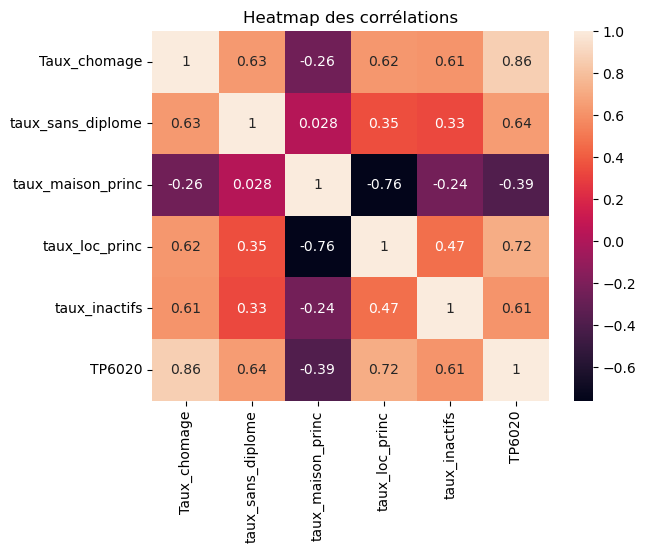

In [18]:
sns.heatmap(data.corr(), annot=True)
plt.title('Heatmap des corrélations')

L’étude des corrélations de ces nouvelles variables ne nous a pas donné entière satisfaction mais il nous a semblé important de trouver un équilibre entre l’approche mathématique et nos réflexions. Après avoir décidé d’arrêter notre choix de variables explicatives à ce stade, nous sommes passés à l’étape de modélisation.

# MODELISATION #

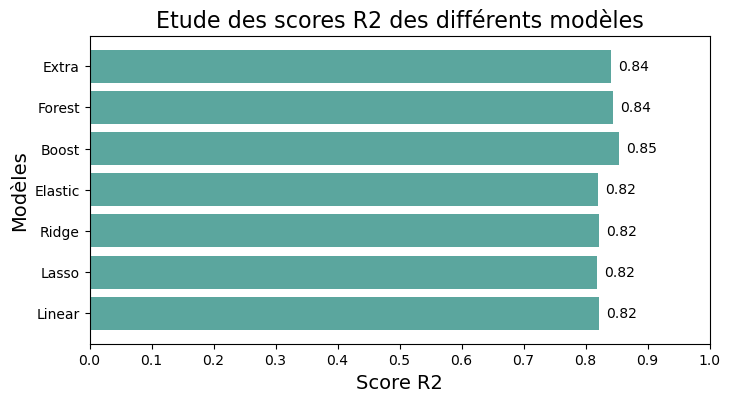

In [19]:
X = data.drop(['CODGEO', 'TP6020'], axis=1)
y = data.TP6020

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


models = [linear_model.LinearRegression(),
         linear_model.Lasso(),
         linear_model.Ridge(),
         linear_model.ElasticNet(),
         ensemble.GradientBoostingRegressor(),
         ensemble.RandomForestRegressor(),
         ensemble.ExtraTreesRegressor()]

model_names = ['Linear', 'Lasso', 'Ridge', 'Elastic', 'Boost', 'Forest', 'Extra']

scores = []
mse = []
mae = []
y_predicts = []

for model in models:
    pipe = Pipeline([('model', model)])
    fits = pipe.fit(X_train, y_train)
    scores.append(metrics.r2_score(y_test, fits.predict(X_test)))
    mse.append(metrics.mean_squared_error(y_test, fits.predict(X_test)))
    mae.append(metrics.median_absolute_error(y_test, fits.predict(X_test)))
    y_predicts.append(pipe.predict(X_test))

fig, ax = plt.subplots(1,1, figsize=(8,4))
barh = ax.barh(model_names, scores, color='#5BA69E')
labels = [np.round(i,2) for i in barh.datavalues]
ax.bar_label(barh, labels=labels, padding=5)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_xlabel('Score R2', fontsize=14)
ax.set_ylabel('Modèles', fontsize=14)
ax.set_title('Etude des scores R2 des différents modèles', fontsize=16)
plt.show()

Les résultats des différents algorithmes sont comparables mais on dénote une meilleure performance pour le RandomForestRegressor et surtout pour le GradientBoostingRegressor avec un score de 0.83.

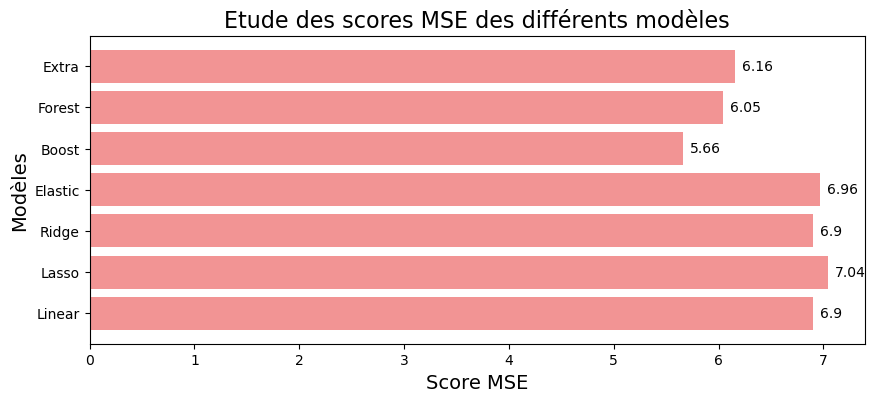

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
barh = ax.barh(model_names, mse, color='#F29494')
labels = [np.round(i,2) for i in barh.datavalues]
ax.bar_label(barh, labels=labels, padding=5)
ax.set_xlabel('Score MSE', fontsize=14)
ax.set_ylabel('Modèles', fontsize=14)
ax.set_title('Etude des scores MSE des différents modèles', fontsize=16)
plt.show()

10 premières lignes de Linear


,y_true,y_predict
2269,19.0,17.463592
1192,20.0,20.339007
2623,13.0,13.418671
3048,15.0,15.188368
120,10.0,13.010687
2572,12.0,14.132811
1454,6.0,9.303870
4045,9.0,7.440646
2970,8.0,9.611639
561,16.0,13.239564


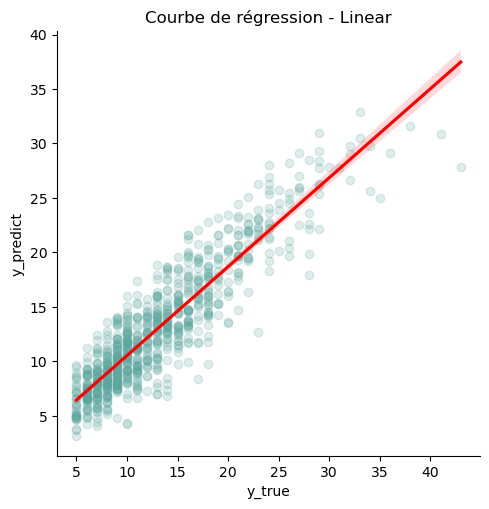

10 premières lignes de Lasso


,y_true,y_predict
2269,19.0,16.989758
1192,20.0,20.540180
2623,13.0,13.109884
3048,15.0,15.444352
120,10.0,13.223637
2572,12.0,14.428402
1454,6.0,9.279751
4045,9.0,7.644848
2970,8.0,9.767403
561,16.0,12.872653


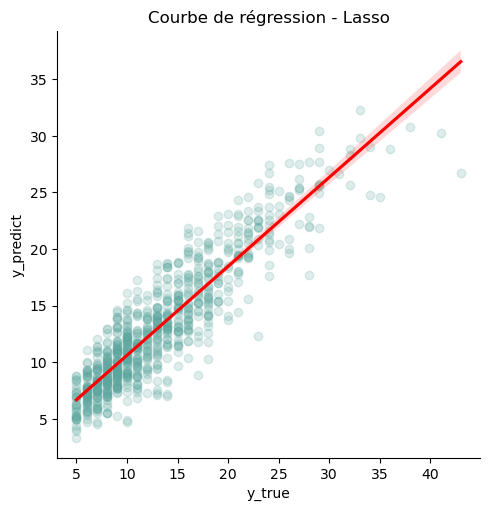

10 premières lignes de Ridge


,y_true,y_predict
2269,19.0,17.463567
1192,20.0,20.338991
2623,13.0,13.418659
3048,15.0,15.188395
120,10.0,13.010669
2572,12.0,14.132835
1454,6.0,9.303882
4045,9.0,7.440657
2970,8.0,9.611638
561,16.0,13.239543


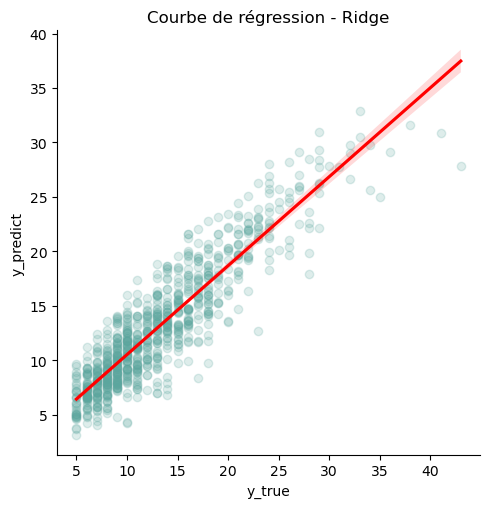

10 premières lignes de Elastic


,y_true,y_predict
2269,19.0,17.200582
1192,20.0,20.394269
2623,13.0,13.260891
3048,15.0,15.345131
120,10.0,13.075196
2572,12.0,14.304302
1454,6.0,9.321688
4045,9.0,7.562298
2970,8.0,9.687212
561,16.0,13.042445


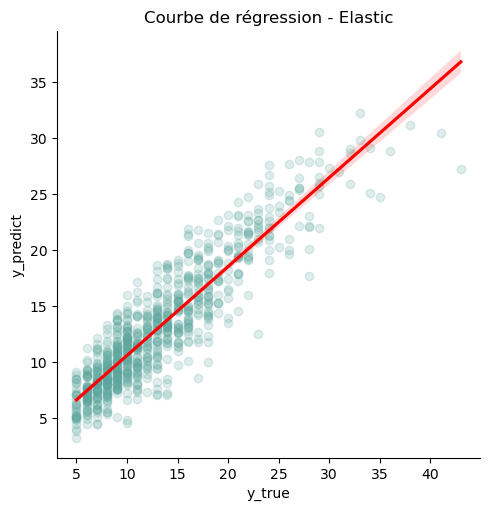

10 premières lignes de Boost


,y_true,y_predict
2269,19.0,17.063505
1192,20.0,20.254529
2623,13.0,12.487215
3048,15.0,13.986156
120,10.0,12.165844
2572,12.0,13.571657
1454,6.0,8.581231
4045,9.0,6.588371
2970,8.0,8.636249
561,16.0,11.936999


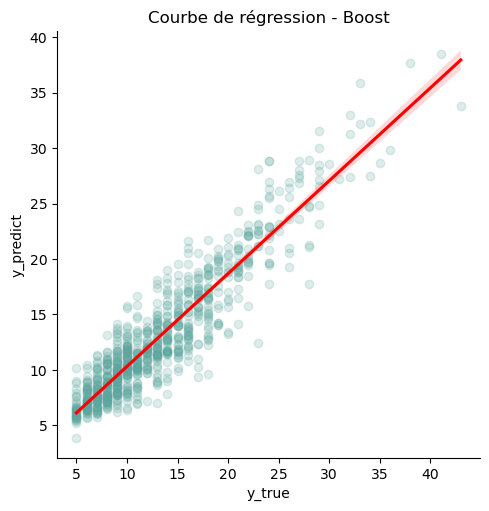

10 premières lignes de Forest


,y_true,y_predict
2269,19.0,17.20
1192,20.0,20.12
2623,13.0,12.35
3048,15.0,13.81
120,10.0,13.07
2572,12.0,14.06
1454,6.0,7.66
4045,9.0,6.72
2970,8.0,8.41
561,16.0,12.31


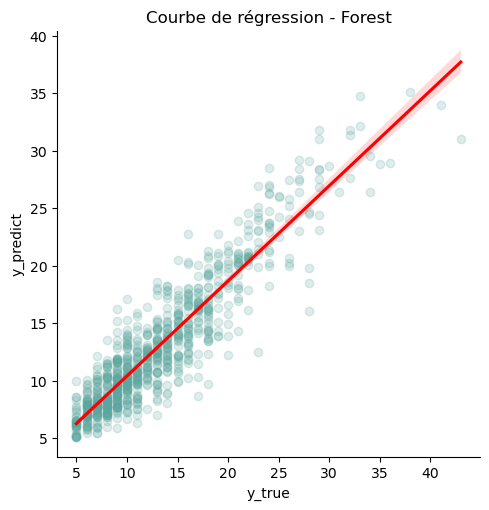

In [21]:
for i in range(0, np.size(model_names) -1):
    print('10 premières lignes de '+model_names[i])
    results = pd.DataFrame({'y_true': y_test, 'y_predict': y_predicts[i]})
    display(results.head(10))
    sns.lmplot(data=results, x='y_true', y='y_predict', lowess = False, line_kws={'color': 'red'}, scatter_kws={"color": '#5BA69E', 'alpha': 0.2})
    plt.xlabel('y_true')
    plt.ylabel('y_predict')
    plt.title('Courbe de régression - '+model_names[i])
    plt.show()


## MODELE RETENU ##

Suivant notre pipeline et les graphs comparatifs, le GradientBoostingRegressor semble le plus adapté

In [22]:
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)
metrics.r2_score(y_test, model.predict(X_test))

0.8537574776150832

## FEATURE IMPORTANCES ##

Quelles sont les variables que notre modèle considère comme les plus importantes pour son fonctionnement ?

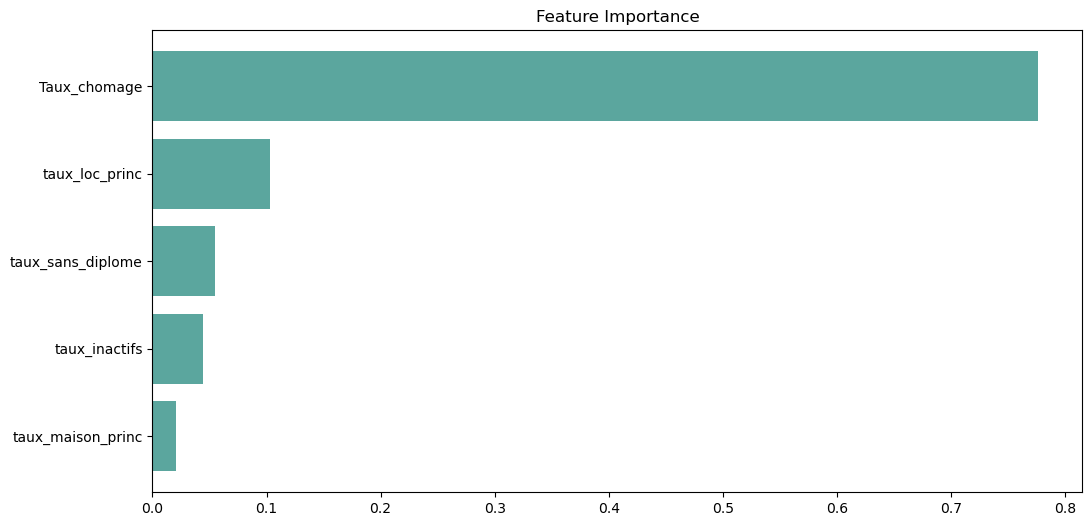

In [23]:
feature_names = X_train.columns
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center", color='#5BA69E')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance")


plt.show()

On observe que le taux de chômage est de loin la variable la plus importante du modèle.  
Les 3 variables suivantes sortent légérement du lot. Il s'agit des variables avec des corrélations positives, en plus du taux de chômage.  
Les variables à corrélations négatives occupent les 3 dernières positions.

## TEST DU MODELE AVEC LES 4 PREMIERES FEATURE IMPORTANCE ##

In [24]:
#On retire les 3 dernières variables de notre graphique Feature Importances
data_4feats = data.drop(['taux_maison_princ'], axis=1)

In [25]:
data_4feats.head()

,CODGEO,Taux_chomage,taux_sans_diplome,taux_loc_princ,taux_inactifs,TP6020
0,01004,14.77,19.36,52.76,14.99,17.0
1,01007,7.61,13.33,24.29,12.18,7.0
2,01014,13.98,32.39,34.89,16.51,10.0
3,01025,7.14,18.07,13.92,12.42,6.0
4,01031,14.99,31.01,58.31,17.40,19.0


In [26]:
X_4feats = data_4feats.drop(['CODGEO', 'TP6020'], axis=1)
y_4feats = data_4feats.TP6020

X_train_4feats, X_test_4feats, y_train_4feats, y_test_4feats = train_test_split(X_4feats, y_4feats, test_size=0.20, random_state=42)

In [27]:
model_4feats = ensemble.GradientBoostingRegressor()
model_4feats.fit(X_train_4feats, y_train_4feats)
print('score', np.round(metrics.r2_score(y_test_4feats, model_4feats.predict(X_test_4feats)),3))

score 0.846


## TEST DU MODELE AVEC LES 3 PREMIERES FEATURE IMPORTANCE ##

In [28]:
#On retire les 3 dernières variables de notre graphique Feature Importances
data_3feats = data.drop(['taux_sans_diplome','taux_maison_princ'], axis=1)

In [29]:
data_3feats.head()

,CODGEO,Taux_chomage,taux_loc_princ,taux_inactifs,TP6020
0,01004,14.77,52.76,14.99,17.0
1,01007,7.61,24.29,12.18,7.0
2,01014,13.98,34.89,16.51,10.0
3,01025,7.14,13.92,12.42,6.0
4,01031,14.99,58.31,17.40,19.0


In [30]:
X_3feats = data_3feats.drop(['CODGEO', 'TP6020'], axis=1)
y_3feats = data_3feats.TP6020

X_train_3feats, X_test_3feats, y_train_3feats, y_test_3feats = train_test_split(X_3feats, y_3feats, test_size=0.20, random_state=42)

In [31]:
model_3feats = ensemble.GradientBoostingRegressor()
model_3feats.fit(X_train_3feats, y_train_3feats)
print('score', np.round(metrics.r2_score(y_test_3feats, model_3feats.predict(X_test_3feats)),3))

score 0.824


## RECHERCHE DE MEILLEURS PARAMETRES SUR 4 PREMIERES FEATURES #

In [32]:
params = {'n_estimators': range(10,500,10)}


grid = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), param_grid=params, cv=5)
grid.fit(X_train_4feats, y_train_4feats)
print(grid.best_params_)
print(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']])


{'n_estimators': 80}
                   params  mean_test_score  std_test_score
0    {'n_estimators': 10}         0.686526        0.006688
1    {'n_estimators': 20}         0.807786        0.012802
2    {'n_estimators': 30}         0.832985        0.012386
3    {'n_estimators': 40}         0.838898        0.011484
4    {'n_estimators': 50}         0.840347        0.010833
5    {'n_estimators': 60}         0.840642        0.010476
6    {'n_estimators': 70}         0.840658        0.010603
7    {'n_estimators': 80}         0.840866        0.010223
8    {'n_estimators': 90}         0.840807        0.009983
9   {'n_estimators': 100}         0.840461        0.010090
10  {'n_estimators': 110}         0.840358        0.010076
11  {'n_estimators': 120}         0.840159        0.009914
12  {'n_estimators': 130}         0.839979        0.010011
13  {'n_estimators': 140}         0.839945        0.009608
14  {'n_estimators': 150}         0.839411        0.009569
15  {'n_estimators': 160}         0

In [33]:
params = {'n_estimators': [90],
          'learning_rate': [0.1,0.2,0.3,0.4,0.5]}


grid = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), param_grid=params, cv=5)
grid.fit(X_train_4feats, y_train_4feats)
print(grid.best_params_)
print(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']])

{'learning_rate': 0.1, 'n_estimators': 90}
                                       params  mean_test_score  std_test_score
0  {'learning_rate': 0.1, 'n_estimators': 90}         0.840859        0.009961
1  {'learning_rate': 0.2, 'n_estimators': 90}         0.832437        0.008684
2  {'learning_rate': 0.3, 'n_estimators': 90}         0.828412        0.010644
3  {'learning_rate': 0.4, 'n_estimators': 90}         0.821756        0.008442
4  {'learning_rate': 0.5, 'n_estimators': 90}         0.810380        0.009063


In [34]:
params = {'n_estimators': [90],
          'learning_rate': [0.1],
          'min_samples_leaf': [1,2,3,4,5]}


grid = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), param_grid=params, cv=5)
grid.fit(X_train_4feats, y_train_4feats)
print(grid.best_params_)
print(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']])

{'learning_rate': 0.1, 'min_samples_leaf': 2, 'n_estimators': 90}
                                              params  mean_test_score  \
0  {'learning_rate': 0.1, 'min_samples_leaf': 1, ...         0.840849   
1  {'learning_rate': 0.1, 'min_samples_leaf': 2, ...         0.841387   
2  {'learning_rate': 0.1, 'min_samples_leaf': 3, ...         0.840853   
3  {'learning_rate': 0.1, 'min_samples_leaf': 4, ...         0.840453   
4  {'learning_rate': 0.1, 'min_samples_leaf': 5, ...         0.839912   

   std_test_score  
0        0.009890  
1        0.009924  
2        0.009534  
3        0.009692  
4        0.010429  


In [35]:
params = {'n_estimators': [90],
          'learning_rate': [0.1],
          'min_samples_leaf': [2],
         'min_samples_split': [2,3,4,5]}


grid = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), param_grid=params, cv=5)
grid.fit(X_train_4feats, y_train_4feats)
print(grid.best_params_)
print(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']])

{'learning_rate': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 90}
                                              params  mean_test_score  \
0  {'learning_rate': 0.1, 'min_samples_leaf': 2, ...         0.841410   
1  {'learning_rate': 0.1, 'min_samples_leaf': 2, ...         0.841351   
2  {'learning_rate': 0.1, 'min_samples_leaf': 2, ...         0.841355   
3  {'learning_rate': 0.1, 'min_samples_leaf': 2, ...         0.841155   

   std_test_score  
0        0.009957  
1        0.009892  
2        0.009882  
3        0.010102  


In [36]:
params = {'n_estimators': [90],
          'learning_rate': [0.1],
          'min_samples_leaf': [2],
         'min_samples_split': [2],
         'loss': ['squared_error', 'absolute_error', 'huber', 'quantile']}


grid = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), param_grid=params, cv=5)
grid.fit(X_train_4feats, y_train_4feats)
print(grid.best_params_)
print(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']])

{'learning_rate': 0.1, 'loss': 'huber', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 90}
                                              params  mean_test_score  \
0  {'learning_rate': 0.1, 'loss': 'squared_error'...         0.841372   
1  {'learning_rate': 0.1, 'loss': 'absolute_error...         0.836097   
2  {'learning_rate': 0.1, 'loss': 'huber', 'min_s...         0.841552   
3  {'learning_rate': 0.1, 'loss': 'quantile', 'mi...         0.611431   

   std_test_score  
0        0.009909  
1        0.012285  
2        0.008645  
3        0.013785  


In [37]:
params = {'n_estimators': [90],
          'learning_rate': [0.1],
          'min_samples_leaf': [2],
         'min_samples_split': [2],
         'loss': ['huber'],
         'max_depth': [1,2,3,4,5]}


grid = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), param_grid=params, cv=5)
grid.fit(X_train_4feats, y_train_4feats)
print(grid.best_params_)
print(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']])

{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 90}
                                              params  mean_test_score  \
0  {'learning_rate': 0.1, 'loss': 'huber', 'max_d...         0.827776   
1  {'learning_rate': 0.1, 'loss': 'huber', 'max_d...         0.839456   
2  {'learning_rate': 0.1, 'loss': 'huber', 'max_d...         0.841501   
3  {'learning_rate': 0.1, 'loss': 'huber', 'max_d...         0.839578   
4  {'learning_rate': 0.1, 'loss': 'huber', 'max_d...         0.835657   

   std_test_score  
0        0.013514  
1        0.011020  
2        0.008538  
3        0.008166  
4        0.009975  


In [42]:
params = {'n_estimators': [90],
          'learning_rate': [0.1],
          'min_samples_leaf': [2],
         'min_samples_split': [2],
         'loss': ['huber'],
         'max_depth': [3],
         }


grid = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(random_state=42), param_grid=params, cv=4)
grid.fit(X_train_4feats, y_train_4feats)
display(grid.best_params_)
display(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']])

{'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 90}

,params,mean_test_score,std_test_score
0,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",0.840035,0.009315


In [74]:
model_4feats = ensemble.GradientBoostingRegressor(n_estimators= 90,
          learning_rate= 0.07,
          min_samples_leaf= 2,
         min_samples_split= 2,
         loss= 'squared_error',
         max_depth= 5,
         random_state=42)
model_4feats.fit(X_train_4feats, y_train_4feats)
print('score', np.round(metrics.r2_score(y_test_4feats, model_4feats.predict(X_test_4feats)),3))

score 0.847


## CONCLUSION ##

Le tuning du modèle ne semble pas porter ses fruits puisque le score reste quasi identique aux paramètres par défaut du modèle sans cross validation.

On retiendra comme modèle le data_4feats avec les 4 premières features car ces variables semblent les plus cohérentes/pertinentes pour les utilisateurs de ce modèle.

In [39]:
#Sauvegarde du train de l'algorithme retenu
import pickle

pickle_filename = "pauvrete_model.pkl"
with open(pickle_filename, 'wb') as file:
    pickle.dump(model_4feats, file)